## Importovanje bibliotke 

In [1]:
import open3d as o3d 
import laspy as lp 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import joblib


from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,PredefinedSplit
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import accuracy_score,confusion_matrix,silhouette_score,precision_score,recall_score,f1_score

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Definisanje funkcija za preocesiranje podataka

In [2]:
'''Funkcija na osonvu zscore vrednosti koji utklanja tacke bazirano na tome da li visina tacke se nalazi mnogo 
iznad ostalih  tacaka. Ideja je da funkcija otlkloni grube greske ali u zavisnoti od paramettra Z moze i da otkloni tacke
koje su na visokom objektu (dom za asistente)'''

def remove_outliners(points,zscore):
    z = np.abs(stats.zscore(points['z']))
    return points[z<zscore].copy()

In [3]:
'''Funkcija splitvuje podatke na X matricu koja sadrzi vektore karakteristika koji ne ukljucuje X,Y koordinate, zato sto nam 
one nisu pogodne za samo treniranje a pogodone su nam za segmentaciju, stoga ovu funkciju pozivamo tek kada izvrsimo 
segmentaciju '''

def splitovanje(podaci):
    podaci_train = podaci.drop(['x','y'],axis=1).dropna()
    X = podaci_train.drop('klase',axis=1)
    y = podaci_train['klase'].copy()
    return shuffle(X,y) 



In [4]:
"""Funkcija koja plotuje sortirane distance svake tacke do svog treceg komsije """

def kurvature(data,tacka = None):
    points = data[['x','y','z']].copy()
    min_samples = 2*len(points.columns)
    neighbor = NearestNeighbors(n_neighbors = min_samples)
    neighbor.fit(points)
    distance, instance = neighbor.kneighbors(points)
    distance = np.sort(distance, axis=0)
    distances = distance[:,2]
    tangente =  np.gradient(distances)
    tangente_2=np.gradient(tangente)
    srednja_tangenta = tangente.mean()
    a = tangente[np.argmin(np.abs(tangente - srednja_tangenta))]
    c = instance[np.argmin(np.abs(tangente-a))]
    epsilon =(distances[c][0])
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(211)
    ax.plot(distances)
    ax.scatter (c,distances[c])
    ax.scatter(c[0],epsilon,color = 'red')
    ax = plt.subplot(212)
    ax.plot(distances)
    ax.scatter (c,distances[c])
    ax.scatter(c[0],epsilon,color = 'red')
    ax.axis([np.min(c)-2e5,np.max(c)+5e5,0,epsilon+5])
    print(distances[c])
    print('Uzeta vrednost za epsilon je:',epsilon)
    plt.show()
    
    if tacka is not None:
        plt.figure(figsize=(12, 4))
        plt.plot(distances)
        plt.scatter(tacka,distances[tacka],color = 'green')
        plt.axis([tacka-2e5,tacka+5e5,0,distances[tacka]+5])
        plt.show()
        print('Vrednost odabrane tacke je:',distances[tacka])
        return epsilon,min_samples,tacka
    
    return epsilon,min_samples
    

In [5]:
'''Funkcija grupneStatistike kao ulaz prima podatke koju za svaku instancu imaju grupu kojoj pripadaju. Zatim grupuiše podatke
na osnovu te grupu i izračuna prosečnu visinu i itezitet kao i standardnu devijaciju za svaku tačku, zatim te izračunate 
vrednosti merge-uje sa originalnim podacima preko klastera kojim pripadaju i pošto nam sam podatak o grupi više ne treba 
uklolnima ga '''

def grupneStatistike(podaci):
    z_stat = podaci.groupby('grupa').z.agg(['mean','std'])
    inten_stat = podaci.groupby('grupa').intensity.agg(['mean','std'])
    first = pd.merge(podaci,z_stat,left_on = 'grupa',right_index = True)
    return pd.merge(first,inten_stat,left_on ='grupa',right_index =True).drop('grupa',axis=1)


'''Funkcija segmentacija vrši segmentaciju tačaka pomoću DBSCAN-a i svakoj tački dodeljuje segment kome pripada
Kada je segmentacija završena funkcija takodje izbacuju vizualizaciju te naše segmentacije, i na kraju poziva prethodne 
dve funkcije (grupneStatistsike i splitovanje) i to funckija vraća'''

def segmentacija(data,epsilon,min_samples):
    points = data[['x','y','z']].copy()
    colors = data[['red','green','blue']].copy()
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points.values)
    dbscan = DBSCAN(eps= epsilon, min_samples= min_samples)# do ovih parametara sam dosao u drugom Notebook-u koristići motodu koju sam u wordu opisao
    dbscan.fit(points)
    labels = dbscan.labels_
    max_labels = labels.max()
    colors_ = plt.get_cmap('tab20')(labels/max_labels if max_labels > 0 else 1)
    colors_[labels ==-1] = 0
    pcd.colors = o3d.utility.Vector3dVector(colors_[:,:3])
    o3d.visualization.draw_geometries([pcd])
    data['grupa'] = labels.reshape(-1,1)
    return splitovanje(grupneStatistike(data)).copy()

In [6]:
"""Ideja funkcije redukcija_boja je da se odradi kvantizacija boja na osnovu KMeans- algoritma"""

def redukcija_boja(kmeans,podaci):
    colors = podaci[['red','green','blue']].copy()
    boje_klasteri = kmeans.predict(colors)
    podaci[['red','green','blue']] = kmeans.cluster_centers_[boje_klasteri]
    return podaci

In [7]:
"""Funkcija koja spaja prethodne funkcije u jednu"""

def preprocess_data(data,zscore,epsilon,min_samples):
    data1 = remove_outliners(data,zscore)
    return segmentacija(data1,epsilon,min_samples)

def preprocess_data_boje(data,kmeans,zscore,epsilon,min_samples):
    data1 = remove_outliners(data,zscore)
    data2 = redukcija_boja(kmeans,data1)
    return segmentacija(data2,epsilon,min_samples)

In [8]:
"""Funkciaj koja kao izlaz daje preciznost modela i matricu konfuzije nad trening i test podacima, kao i bitnost feature-a
ukoliko je model RandomForest"""

def izvestaj_statistike(y,y_pred,train = True):
    if train is True:
        print('Tacnost na trening podacima je:\n',accuracy_score(y,y_pred),'\n')
        print('Matrica konfuzije za trening podatke:\n')
        trening_konfuzija=pd.DataFrame(confusion_matrix(y,y_pred),columns = klase,index = klase)
        display(trening_konfuzija)
        print('Preciznost nad trening podacima:',precision_score(y,y_pred))
        print('Odziv nad trening podacima je:',recall_score(y,y_pred))
        print('F1 vrednost nad trening podacima je:',f1_score(y,y_pred))
        trening = trening_konfuzija.values
        np.fill_diagonal(trening,0)
        plt.imshow(trening,cmap = plt.cm.gist_heat_r)
        plt.show()
    if train is False:
        print('Tacnost na test podacima je:\n',accuracy_score(y,y_pred),'\n')
        print('Matrica konfuzije za test podatke:\n')
        testing_konfuzija=pd.DataFrame(confusion_matrix(y,y_pred),columns = klase,index = klase)
        display(testing_konfuzija)
        print('Preciznost nad testing podacima:',precision_score(y,y_pred))
        print('Odziv nad testing podacima je:',recall_score(y,y_pred))
        print('F1 vrednost nad testing podacima je:',f1_score(y,y_pred))
        testing = testing_konfuzija.values
        np.fill_diagonal(testing,0)
        plt.imshow(testing,cmap = plt.cm.gist_heat_r)
        plt.show()
        

def izvestaj(model,X_train,X_test,y_train,y_test,klase=None,columns = None):
    
    if str(type(model)) =="<class 'tensorflow.python.keras.engine.sequential.Sequential'>":


        if len(np.unique(y_train))!=2:
            y_predict = model.predict(X_train).argmax(axis=1)
            izvestaj_statistike(y_train,y_predict)

            y_predict_test = model.predict(X_test).argmax(axis=1)
            izvestaj_statistike(y_test,y_predict_test,train= False)
        if len(np.unique(y_train))==2:
            y_predict = model.predict(X_train)>0.5
            izvestaj_statistike(y_train,y_predict)

            y_predict_test = model.predict(X_test)>0.5
            izvestaj_statistike(y_test,y_predict_test,train= False)
    else:
        
            y_predict = model.predict(X_train)
            izvestaj_statistike(y_train,y_predict)
            
            

            y_predict_test = model.predict(X_test)
            izvestaj_statistike(y_test,y_predict_test,train= False)

        
        
    try:   
        if str(type(model))=="<class 'sklearn.ensemble._forest.RandomForestClassifier'>":
            importance = pd.Series(data = model.feature_importances_,index = columns)
            importance.plot(kind = 'bar')
            plt.show()
    except:
        print()
    try:
        if str(type(model.best_estimator_))=="<class 'sklearn.ensemble._forest.RandomForestClassifier'>":
            importance = pd.Series(data = model.best_estimator_.feature_importances_,index = columns)
            importance.plot(kind = 'bar')
            plt.show()
    except:
        print()

In [9]:
def vizualizacija(X,y,podaci):
    koordinate =podaci.loc[X.index,['x','y','z']]
    broj_klase=len(np.unique(y))
    if broj_klase==2:
        colors = plt.get_cmap('seismic_r')(y/1)
    else:
        colors = plt.get_cmap('tab10')(y)
        
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(koordinate.values)
    pcd.colors = o3d.utility.Vector3dVector(colors[:,:3])

    o3d.visualization.draw_geometries([pcd])

In [10]:
def vizualizacija_proba(X,y,podaci):
    koordinate =podaci.loc[X.index,['x','y','z']]
    broj_klase=len(np.unique(y))
    if broj_klase==2:
        colors = plt.get_cmap('seismic_r')(y/1)
    else:
        colors = y.map({0:[0.97647059, 0.65490196, 0.24313725],1:[0.15294118, 0.70196078, 0.4627451 ]
                        ,2:[0.74901961, 0.12941176, 0.18431373],3:[0., 0.43529412, 0.23529412]})
        
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(koordinate.values)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    o3d.visualization.draw_geometries([pcd])

In [11]:
def load_index(path):
    return pd.read_csv(path).values.reshape(-1,)

### Ucitavanje KMeans modela koji radi kvantizaciju boja

In [12]:
kmeans = joblib.load(r"C:\Users\ilija\Fax\Diplomski\Seminarski lasersko Avgust\Modeli\redukcijaBoja")

## Multiklase klasfikacija Tlo,Sikara- Zgrade-Vegetacija-Put,Parking

In [13]:
data_valid = pd.read_csv(r"C:\Users\ilija\Fax\Diplomski\Seminarski Septembar\Novi podaci\Zgrade_gornji.csv")
data_train = pd.read_csv(r"C:\Users\ilija\Fax\Diplomski\Seminarski Septembar\Novi podaci\Zgrade_donji.csv")


In [14]:
data_train = data_train[::2].copy()
data_valid = data_valid[::2].copy()

In [15]:
klase = ['Zgrade','Nezgrade']
broj_klasa = len(klase)

In [ ]:
epsilon,min_samples = kurvature(data_train)

In [16]:
epsilon = 0.58
min_samples = 8

In [17]:
X,y = preprocess_data(data_train,3.5,epsilon,min_samples)

In [18]:
vizualizacija(X,y,data_train)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [19]:
transformer = ColumnTransformer([
    ('scaler',StandardScaler(),['z','intensity', 'mean_x', 'std_x', 'mean_y','std_y']),
    ('minMax',MinMaxScaler(),['red', 'green', 'blue'])
],remainder = 'passthrough')

In [23]:
X_scaled = transformer.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled,columns = X.columns,index= X.index)

[1.39405882 1.39405882 1.2292274  1.05479856 1.05494076 1.05489336]
Uzeta vrednost za epsilon je: 1.3940588223477308


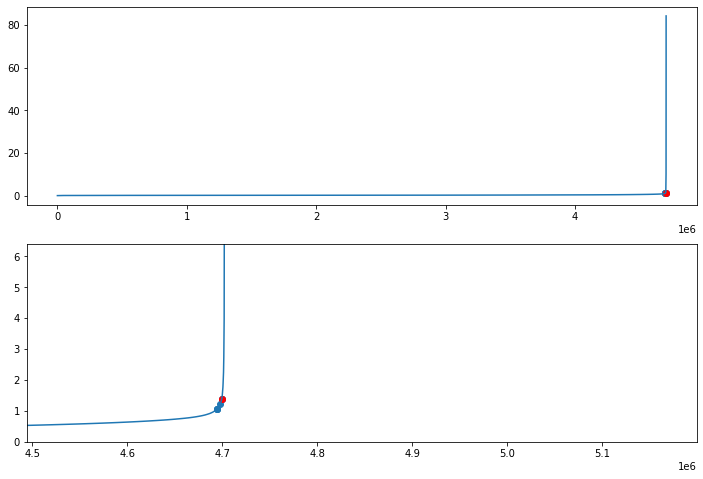

In [69]:
epsilon_valid,min_samples_valid = kurvature(data_valid)

In [20]:
epsilon_valid = 0.58
min_samples_valid = 6

In [21]:
X_valid,y_valid = preprocess_data(data_valid,3.5,epsilon_valid,min_samples_valid)

In [24]:
X_valid_scaled = transformer.transform(X_valid)
X_valid_scaled_df = pd.DataFrame(X_valid_scaled,columns = X_valid.columns,index = X_valid.index)

In [25]:
X_train = pd.concat([X_scaled_df,X_valid_scaled_df])
y_train = pd.concat([y,y_valid])

## Klasifikacija pomocu stohastickog gradijentnog pada

In [29]:
X_train.index

Int64Index([ 8026472,  4691406,  7614502,  7548400, 12018746,  6642620,
             8131288,   562876, 11155174, 10215802,
            ...
            10417106,   522236,  7628358,  4526760,  5606388, 13538486,
             5251836,  3805474,    88098,   556610],
           dtype='int64', length=13493702)

In [30]:
split_index = np.full(len(X_train),-1)
split_index[len(X):]=0

In [31]:
fold = np.array(split_index)

In [32]:
fold

array([-1, -1, -1, ...,  0,  0,  0])

In [33]:
(7638774)/12337102

0.6191708555218235

In [34]:
np.mean(fold)

-0.4842476882919157

In [35]:
pds = PredefinedSplit(test_fold = fold)

In [36]:
clf = SGDClassifier( class_weight='balanced', penalty='elasticnet', random_state=42)
param_dist = {'l1_ratio': stats.uniform(0, 1),
              'alpha': stats.loguniform(1e-4, 1e0)}

n_iter = 20
rand_search = RandomizedSearchCV(clf,param_dist,n_iter=n_iter,n_jobs = -1,cv=pds)

In [37]:
rand_search.fit(X_train,y_train)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=SGDClassifier(class_weight='balanced',
                                           penalty='elasticnet',
                                           random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000274EBC85B50>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000274EBC85820>})

In [38]:
rand_search.score(X_scaled,y)

0.9483576955674171

In [39]:
rand_search.best_estimator_

SGDClassifier(alpha=0.00014137381792567476, class_weight='balanced',
              l1_ratio=0.8008093735509733, penalty='elasticnet',
              random_state=42)

In [40]:
rand_search.best_estimator_.coef_

array([[-0.7112917 , -0.3913756 , -0.88850684,  0.09333214, -1.12350097,
        -0.90875357, -2.92075958, 10.72827095, -9.10786009]])

In [41]:
pd.DataFrame(rand_search.best_estimator_.coef_,columns = X.columns,index = ['Zgrade'])

,z,red,green,blue,intensity,mean_x,std_x,mean_y,std_y
Zgrade,-0.711292,-0.391376,-0.888507,0.093332,-1.123501,-0.908754,-2.92076,10.728271,-9.10786


In [42]:
data_test = pd.read_csv(r"C:\Users\ilija\Fax\Diplomski\Seminarski Septembar\Novi podaci\zgrade_novi.csv")

In [43]:
data_test

,x,y,z,red,green,blue,intensity,klase
0,409137.06,5010684.11,82.33,13568.0,19200.0,23552.0,260.0,0
1,409137.20,5010683.70,82.34,13568.0,19968.0,23552.0,185.0,0
2,409136.87,5010683.74,82.32,14848.0,20736.0,24576.0,947.0,0
3,409136.54,5010683.79,82.32,16384.0,21760.0,26112.0,306.0,0
4,409136.24,5010683.83,82.28,15360.0,20480.0,24576.0,8.0,0
...,...,...,...,...,...,...,...,...
11738479,409281.67,5010073.73,76.47,41472.0,41472.0,42752.0,49.0,1
11738480,409281.00,5010072.27,76.45,40192.0,39680.0,40704.0,100.0,1
11738481,409280.98,5010072.66,76.45,38656.0,38656.0,39424.0,74.0,1
11738482,409280.95,5010073.08,76.46,35328.0,36096.0,38144.0,65.0,1


[1.36832014 1.36707717 1.23032516 1.37237021 1.36707717 1.36835668]
Uzeta vrednost za epsilon je: 1.3683201379911283


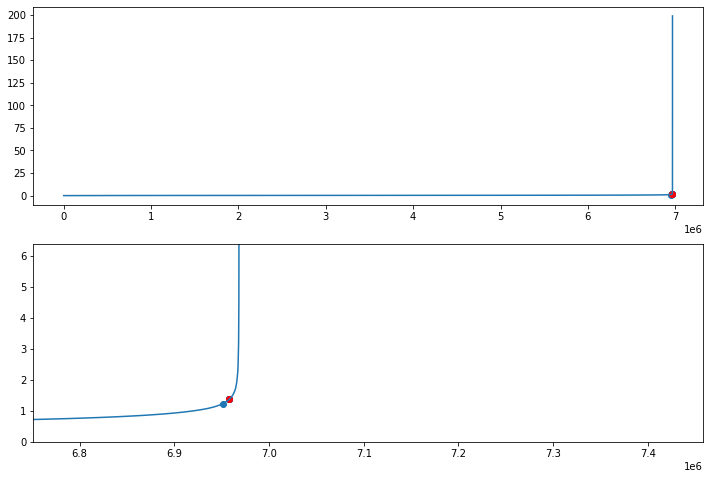

In [59]:
epsilon_test, min_samples = kurvature(data_test)

In [44]:
epsilon_test = 0.59
min_samples = 6

In [45]:
X_test,y_test = preprocess_data(data_test,3.5,epsilon_test,min_samples)

In [46]:
X_test_scaled = transformer.transform(X_test)

In [45]:
vizualizacija(X_test,y_test,data_test)

### Prikaz rezultata

Tacnost na trening podacima je:
 0.9483576955674171 

Matrica konfuzije za trening podatke:



,Zgrade,Nezgrade
Zgrade,1089285,179319
Nezgrade,158127,5107563


Preciznost nad trening podacima: 0.9660822768505142
Odziv nad trening podacima je: 0.9699703172803564
F1 vrednost nad trening podacima je: 0.968022393024184


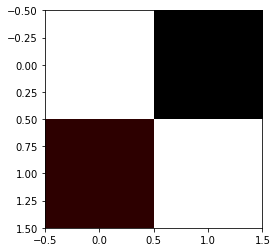

Tacnost na test podacima je:
 0.9175779031779715 

Matrica konfuzije za test podatke:



,Zgrade,Nezgrade
Zgrade,1720310,249627
Nezgrade,323982,4665489


Preciznost nad testing podacima: 0.949212388883599
Odziv nad testing podacima je: 0.9350668638017938
F1 vrednost nad testing podacima je: 0.9420865302106993


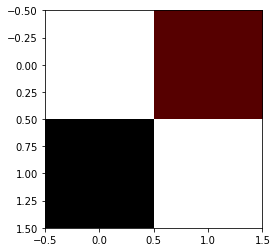

In [128]:
izvestaj(rand_search,X_scaled,X_valid_scaled,y,y_valid,klase = klase)

In [53]:
vizualizacija(X_test,rand_search.predict(X_test_scaled),data_test)

In [55]:
y_score =rand_search.decision_function(X_test)

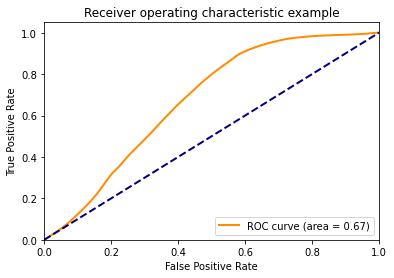

In [59]:
from sklearn.metrics import auc,roc_curve
fpr,tpr,threshold= roc_curve(y_test,y_score)
roc_auc = auc(fpr, tpr)



plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [71]:
thr = threshold[(fpr> 0.55).argmax()]

In [72]:
decision = rand_search.decision_function(X_test) 

In [73]:
y_ppred = decision >thr

Tacnost na trening podacima je:
 0.7825475895191406 

Matrica konfuzije za trening podatke:



,Zgrade,Nezgrade
Zgrade,977374,1194567
Nezgrade,1337301,8134078


Preciznost nad trening podacima: 0.8719463544812778
Odziv nad trening podacima je: 0.8588060936005201
F1 vrednost nad trening podacima je: 0.8653263421365845


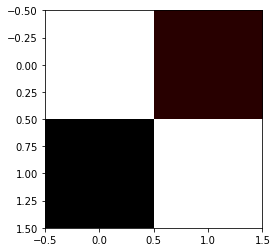

In [74]:
izvestaj_statistike(y_test,y_ppred)

## Mutliklasna klasifikacija primenom algoritma neuronske mreze

In [62]:
model = Sequential([
    Dense(15,activation='relu',input_shape = [9],kernel_regularizer = l2(0.001)),
    Dense(1,activation = 'sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer = 'adam',metrics = ['binary_accuracy'])
model.fit(X_scaled,y,validation_data = (X_valid_scaled,y_valid), epochs = 100, callbacks = EarlyStopping(patience= 2))

Epoch 1/100
204197/204197 [==============================] - 948s 5ms/step - loss: 0.1012 - binary_accuracy: 0.9682 - val_loss: 0.1741 - val_binary_accuracy: 0.9474
Epoch 2/100
204197/204197 [==============================] - 994s 5ms/step - loss: 0.0812 - binary_accuracy: 0.9734 - val_loss: 0.1664 - val_binary_accuracy: 0.9501
Epoch 3/100
204197/204197 [==============================] - 634s 3ms/step - loss: 0.0799 - binary_accuracy: 0.9737 - val_loss: 0.1696 - val_binary_accuracy: 0.9450
Epoch 4/100
204197/204197 [==============================] - 630s 3ms/step - loss: 0.0794 - binary_accuracy: 0.9738 - val_loss: 0.1790 - val_binary_accuracy: 0.9455


Tacnost na trening podacima je:
 0.9740401947019831 

Matrica konfuzije za trening podatke:



,Zgrade,Nezgrade
Zgrade,1177298,91306
Nezgrade,78323,5187367


Preciznost nad trening podacima: 0.9827028497503065
Odziv nad trening podacima je: 0.985125785984363
F1 vrednost nad trening podacima je: 0.9839128262181414


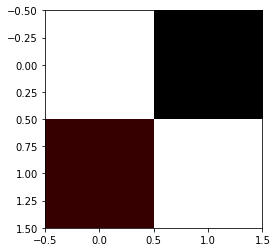

Tacnost na test podacima je:
 0.9711100442141932 

Matrica konfuzije za test podatke:



,Zgrade,Nezgrade
Zgrade,1928222,243719
Nezgrade,92656,9378723


Preciznost nad testing podacima: 0.9746718140779648
Odziv nad testing podacima je: 0.990217264033041
F1 vrednost nad testing podacima je: 0.9823830442319533


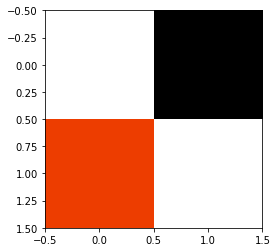

In [96]:
izvestaj(model,X_scaled,X_test_scaled,y,y_test,klase = klase)

In [71]:
model.save('klasifikacija_zgrade_NN.h5')

In [79]:
import tensorflow
model = tensorflow.keras.models.load_model('klasifikacija_zgrade_NN.h5')

In [82]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                150       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 166
Trainable params: 166
Non-trainable params: 0
_________________________________________________________________


In [123]:
y_model_ppred =model.predict(X_scaled)

In [124]:
y_model_ppred

array([[0.99856377],
       [0.96438676],
       [0.9998867 ],
       ...,
       [0.87852615],
       [0.99829704],
       [0.99906915]], dtype=float32)

In [125]:
fpr,tpr,threshold = roc_curve(y,y_model_ppred)
roc_auc = auc(fpr,tpr)

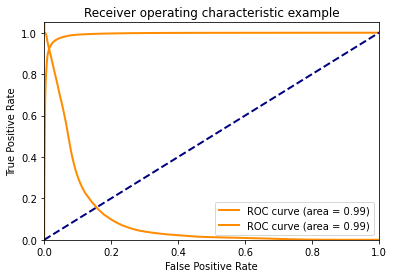

In [126]:
lw = 2
plt.plot(fpr,np.array([tpr,threshold]).T, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [121]:
threshold[np.argmin(np.abs(threshold-tpr))]

0.9413507

In [112]:
threshold[()]

array([2.0000000e+00, 1.0000000e+00, 9.9999988e-01, ..., 2.6780164e-16,
       2.6755452e-16, 4.1229954e-23], dtype=float32)

In [117]:
np.array([tpr,threshold]).T

array([[0.00000000e+00, 2.00000000e+00],
       [6.68540452e-04, 1.00000000e+00],
       [7.95871435e-04, 9.99999881e-01],
       ...,
       [1.00000000e+00, 2.67801642e-16],
       [1.00000000e+00, 2.67554521e-16],
       [1.00000000e+00, 4.12299541e-23]])

Tacnost na trening podacima je:
 0.9532897833264052 

Matrica konfuzije za trening podatke:



,Zgrade,Nezgrade
Zgrade,2032839,139102
Nezgrade,404760,9066619


Preciznost nad trening podacima: 0.9848896137521439
Odziv nad trening podacima je: 0.9572649347048618
F1 vrednost nad trening podacima je: 0.9708808112608488


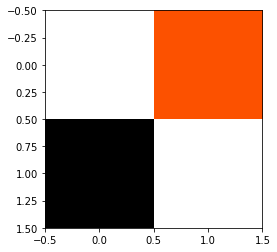

In [122]:
izvestaj_statistike(y_test,y_model_ppred>0.9)